# language analysis

This script analyzes the differences in languages that emerge given agents with different visual biases. The metric that is used to quantify differences in language is the effectiveness score. Effectiveness scores are used to measure how well information about all object attributes is communicated, as well as to measure how well information about individual attributes is communicated. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from utils.bootstrap_ci import bootstrap_mean_difference, bootstrap_mean
import string
import numpy as np

In [2]:
def plot_language_bias_sender_versus_receiver(conditions, names, featurewise_effectiveness, n_biases=5, n_runs=20,
                                              flexible_role=False, mixed_bias=False):    
    plt.figure(figsize=(12,9))

    for i, condition in enumerate(conditions):
        plt.subplot(3,1,i+1)
        listed_effectiveness = {}
        for entry in ['name', 'attribute', 'run', 'effectiveness']:
            listed_effectiveness[entry] = []

        for old_name in names[i]:
            if '_default' in old_name: 
                name = old_name.split('_default')[0]
            elif 'default_' in old_name: 
                name = old_name.split('default_')[1]
            elif '_' in old_name: 
                name = old_name.split('_')[0]
            else: 
                name = old_name
            for feature in ['color', 'scale', 'shape']:
                for r in range(n_runs): 
                    listed_effectiveness['name'].append(name)
                    listed_effectiveness['attribute'].append(feature)
                    listed_effectiveness['run'].append(r)
                    listed_effectiveness['effectiveness'].append(
                        featurewise_effectiveness[condition][old_name][feature][r])
        p = sns.barplot(x='name', y='effectiveness', hue="attribute", ci=95, data=listed_effectiveness, n_boot=10000) 
        plt.xlabel('agent bias', fontsize=15)
        plt.ylabel('E($O_a$|$M$)', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks([0,1], fontsize=15)
        
        if flexible_role:
            plt.title(['biased agent: biased agent 1 - biased agent 2', 
                       'biased agent: default agent 1 - biased agent 2',
                       'default agent: default agent 1 - biased agent 2'][i],
                      fontsize=15)            

        if mixed_bias:
            a, b = condition.split('_')
            plt.title(a + ' ' + b, fontsize=15)
        if not mixed_bias and not flexible_role: 
            plt.title(['sender biased, receiver biased', 
                        'sender biased, receiver default', 
                        'sender default, receiver biased'][i],
                      fontsize=15)
            

        ax = plt.gca()
        ax.text(-0.08, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, 
                size=20, weight='bold')

        darkgray = [0.3,0.3,0.3]
        gray = [0.5,0.5,0.5]
        
        labels = ['color']*n_biases + ['scale']*n_biases + ['shape']*n_biases
        if n_biases == 3: 
            color_patches = [gray, gray, darkgray, 
                             gray, darkgray, darkgray, 
                             gray, gray, darkgray]
        elif n_biases == 5: 
            color_patches = [gray, darkgray, gray, gray, darkgray, 
                             gray, gray, darkgray, gray, darkgray, 
                             gray, gray, gray, darkgray, darkgray]
        
        for i, patch in enumerate(p.patches): 
            p.annotate(labels[i],
                       (patch.get_x() + patch.get_width() / 2., 0.2 if n_biases == 5 else 0.18), 
                       ha = 'center', va = 'center', 
                       size=13 if n_biases == 5 else 15,
                       xytext = (0, -12), 
                       color=[1,1,1],
                       textcoords = 'offset points')
            patch.set_color(color_patches[i])
            patch.set_edgecolor([0.2,0.2,0.2])

        for line in p.get_lines(): 
            line.set_color('k')

        p.legend_.remove()

    plt.tight_layout() 

## influence of perception on language, only language modules trained

### effectiveness, sender vs receiver bias 

In [3]:
names = [['default', 'color', 'scale', 'shape', 'all'], 
         ['default', 'color_default', 'scale_default', 'shape_default', 'all_default'],
         ['default', 'default_color','default_scale', 'default_shape', 'default_all']]

featurewise_effectiveness = dict()
conditions = ['sender_biased_receiver_biased', 'sender_biased_receiver_default', 'sender_default_receiver_biased']
for c in conditions: 
    featurewise_effectiveness[c] = dict()
vs = 4
nruns = 20
mode = 'language_emergence_basic'

for i in range(len(names)):
    condition = conditions[i]
    for n in names[i]: 
         featurewise_effectiveness[condition][n] = {'color': [], 'scale': [], 'shape': []}  
    for run in names[i]: 
        for r in range(nruns): 
            run_name = run + str(r)
            scores = pickle.load(
                open('results/' + mode + '/' + run_name + '/vs' + str(vs) + '_ml3/entropy_scores.pkl', 'rb')
            )
            featurewise_effectiveness[condition][run]['color'].append(scores['effectiveness']['color'])
            featurewise_effectiveness[condition][run]['scale'].append(scores['effectiveness']['scale'])
            featurewise_effectiveness[condition][run]['shape'].append(scores['effectiveness']['shape'])

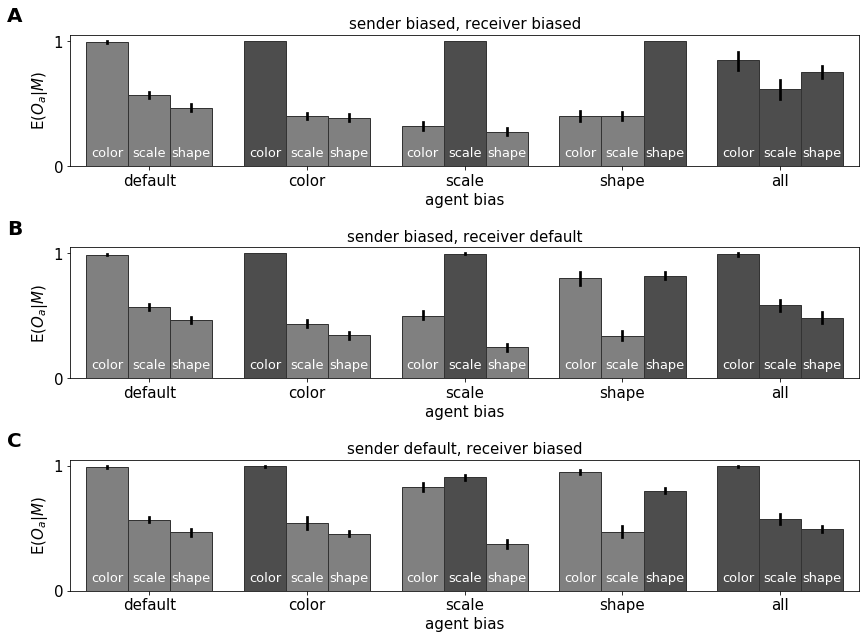

In [6]:
plot_language_bias_sender_versus_receiver(conditions, names, featurewise_effectiveness, n_biases=5, n_runs=20)

#### mean effectiveness across attributes (both agents biased)

In [12]:
condition = featurewise_effectiveness['sender_biased_receiver_biased']
for name in ['default', 'color', 'scale', 'shape', 'all']:
    means = []
    for i in range(20): 
        means.append(np.mean([condition[name]['color'][i], condition[name]['scale'][i], condition[name]['shape'][i]]))
    if name == 'default':
        means_default = means
    elif name == 'all': 
        means_all = means
    print(name + ': mean ', np.mean(means), 'bootstrap ci', bootstrap_mean(means))

default: mean  0.6757232643377277 bootstrap ci (0.012463792009089536, 0.013015989027185926)
color: mean  0.5962651177352607 bootstrap ci (0.014195969925355323, 0.014567410369318301)
scale: mean  0.5324457773466996 bootstrap ci (0.015938590055671775, 0.01559258201850966)
shape: mean  0.6000723832969465 bootstrap ci (0.01919540829108446, 0.02043632256384731)
all: mean  0.7378176158324405 bootstrap ci (0.017223544927449708, 0.015612451719132059)


#### mean effectiveness across attributes (biased sender, default receiver)

In [13]:
condition  = featurewise_effectiveness['sender_biased_receiver_default']
for name in ['color_default', 'scale_default', 'shape_default', 'all_default']:
    means = []
    for i in range(20): 
        means.append(np.mean([condition[name]['color'][i], condition[name]['scale'][i], condition[name]['shape'][i]]))
    print(name + ': mean ', np.mean(means), 'bootstrap ci', bootstrap_mean(means))

color_default: mean  0.5942652032707239 bootstrap ci (0.014962022742300851, 0.014682636424489193)
scale_default: mean  0.5836090488320301 bootstrap ci (0.01526601580772835, 0.016585929540846367)
shape_default: mean  0.6564622593676213 bootstrap ci (0.01883068266412702, 0.018443962958657023)
all_default: mean  0.6877154738263347 bootstrap ci (0.01465849636132821, 0.013660369098011604)


#### mean effectiveness across attributes (default sender, biased receiver)

In [15]:
condition  = featurewise_effectiveness['sender_default_receiver_biased']
for name in ['default_color','default_scale', 'default_shape', 'default_all']:
    means = []
    for i in range(20): 
        means.append(np.mean([condition[name]['color'][i], condition[name]['scale'][i], condition[name]['shape'][i]]))
    print(name + ': mean ', np.mean(means), 'bootstrap ci', bootstrap_mean(means))

default_color: mean  0.6660577956070999 bootstrap ci (0.020420945099628884, 0.019636491962218616)
default_scale: mean  0.705830779252285 bootstrap ci (0.014220376533305434, 0.01484678388513161)
default_shape: mean  0.7416505889048677 bootstrap ci (0.014704829876160397, 0.014812016646653214)
default_all: mean  0.688849446367273 bootstrap ci (0.01400465786903704, 0.014156476537967366)


#### bootstrapped CIs: default versus all condition

In [40]:
bootstrap_mean_difference(means_all, means_default)

(0.04030811461706874, 0.08250491782896077)

#### bootstrapped CIs: biased versus unbiased attributes

In [5]:
data = featurewise_effectiveness['sender_biased_receiver_biased']
data_biased = []
data_unbiased = []
for name in names[0]: 
    if name == 'default': 
        for key in data[name].keys(): 
            data_unbiased += data[name][key]
    elif name == 'all': 
        for key in data[name].keys(): 
            data_biased += data[name][key]
    else: 
        for key in data[name].keys(): 
            if key==name: 
                data_biased += data[name][key]
            else: 
                data_unbiased += data[name][key]

print("mean biased:", np.mean(data_biased), "mean unbiased:", np.mean(data_unbiased))
print("bootstrapped CI for difference in means:", bootstrap_mean_difference(data_biased, data_unbiased, n=10000))

mean biased: 0.8688792828003671 mean unbiased: 0.4681885309827803
bootstrapped CI for difference in means: (0.3546805127103315, 0.44372279878517285)


#### bootstrapped CIs: biased sender versus biased receiver 

In [44]:
# color, scale shape conditions
# difference between biasing one agent and biasing both agents

both_biased = featurewise_effectiveness['sender_biased_receiver_biased']
sender_biased = featurewise_effectiveness['sender_biased_receiver_default']
receiver_biased = featurewise_effectiveness['sender_default_receiver_biased']

abs_diff_sender = 0
abs_diff_receiver = 0
for bias in ['color', 'scale', 'shape']:
    for attribute in ['color', 'scale', 'shape']:
        abs_diff_sender += np.abs(np.mean(both_biased[bias][attribute]) - 
                                  np.mean(sender_biased[bias + '_default'][attribute]))
        abs_diff_receiver += np.abs(np.mean(both_biased[bias][attribute]) - 
                                    np.mean(receiver_biased['default_' + bias][attribute]))
        
print(abs_diff_receiver / 9, abs_diff_sender / 9)

0.19354943884118603 0.10262478294552238


In [11]:
# all condition
# difference between default-all or all-default combinations and default-default combination

both_biased = featurewise_effectiveness['sender_biased_receiver_biased']
sender_biased = featurewise_effectiveness['sender_biased_receiver_default']
receiver_biased = featurewise_effectiveness['sender_default_receiver_biased']

abs_diff_sender = 0
abs_diff_receiver = 0
for attribute in ['color', 'scale', 'shape']:
    abs_diff_sender += np.abs(np.mean(both_biased['default'][attribute]) - 
                              np.mean(sender_biased['all_default'][attribute]))
    abs_diff_receiver += np.abs(np.mean(both_biased['default'][attribute]) - 
                                np.mean(receiver_biased['default_all'][attribute]))
    
print(abs_diff_receiver / 3, abs_diff_sender / 3)

0.013126182029545408 0.011992209488607056


# control: larger vocab size, more distractors

In [47]:
conditions = ['default', 'color', 'scale', 'shape', 'all']

effectiveness = {'condition':[], 'attribute':[], 'vocab_size':[], 'distractors':[], 'effectiveness':[], 'test_rewards':[]}
vocab_size = [4,8,12]
distractors = [2,8]
n_runs = 10

for condition in conditions:
    for vs in vocab_size: 
        for n_dist in distractors: 
            if n_dist == 2: 
                mode = 'language_emergence_basic'
            else: 
                mode = 'language_emergence_eight_distractors'
            for r in range(n_runs): 
                scores = pickle.load(
                    open('results/' + mode + '/' + condition + str(r) + '/vs' + str(vs) + '_ml3/entropy_scores.pkl', 'rb')
                )
                rewards = np.load(
                    'results/' + mode + '/' + condition + str(r) + '/vs' + str(vs) + '_ml3/test_reward.npy'
                )
                effectiveness['condition'] += [condition]*3
                effectiveness['distractors'] += [n_dist]*3
                effectiveness['vocab_size'] += [vs]*3
                effectiveness['attribute'] += ['color', 'scale', 'shape']
                effectiveness['effectiveness'] += [scores['effectiveness']['color'],
                                                   scores['effectiveness']['scale'],
                                                   scores['effectiveness']['shape']]  
                effectiveness['test_rewards'] += [rewards[-1]]*3
effectiveness = pd.DataFrame(data=effectiveness)

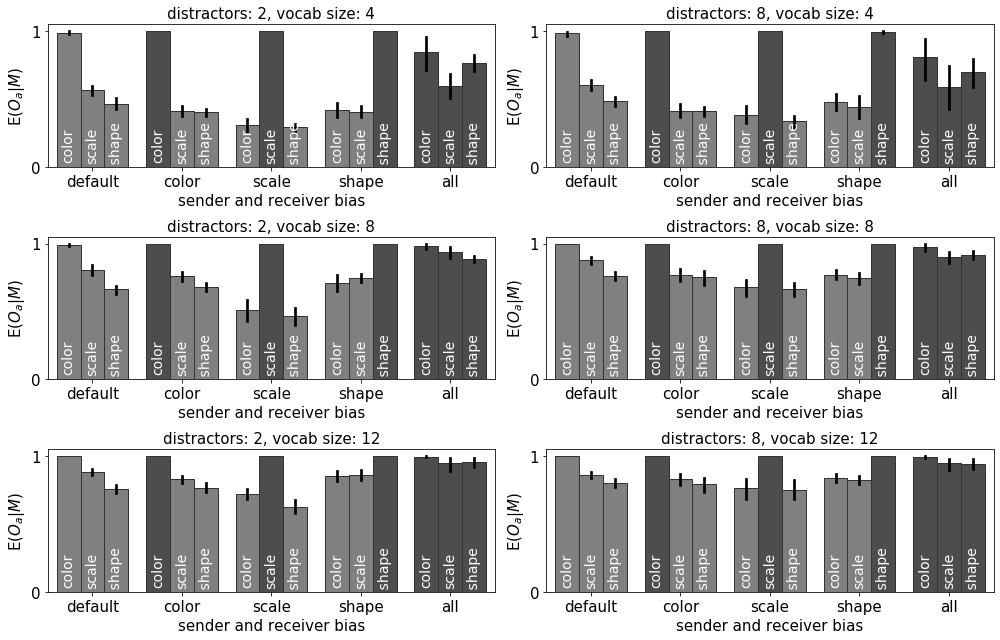

In [48]:
plt.figure(figsize=(14,9))

for j, vs in enumerate([4,8,12]):
    for i, dist in enumerate([2,8]):
        plt.subplot(3,2,j*2+i+1)
        p = sns.barplot(x='condition', y='effectiveness', hue='attribute', n_boot=10000,
                        data=effectiveness[(effectiveness.distractors==dist) & (effectiveness.vocab_size==vs)])
        plt.title('distractors: ' + str(dist) + ', vocab size: ' + str(vs), fontsize=15)
        plt.xlabel('sender and receiver bias', fontsize=15)
        plt.ylabel('E($O_a$|$M$)', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks([0,1], fontsize=15)
        
        
        darkgray = [0.3,0.3,0.3]
        gray = [0.5,0.5,0.5]
        labels = ['color']*5 + ['scale']*5 + [' shape']*5
        for k, patch in enumerate(p.patches): 
            p.annotate(labels[k],
                       (patch.get_x() + patch.get_width() / 2., 0.2), 
                       ha = 'center', va = 'center', 
                       size=14,
                       xytext = (0, -5), 
                       color=[1,1,1],
                       textcoords = 'offset points', 
                       rotation='vertical'
                      )
            patch.set_color([gray, darkgray, gray, gray, darkgray, 
                             gray, gray, darkgray, gray, darkgray, 
                             gray, gray, gray, darkgray, darkgray][k])
            patch.set_edgecolor([0.2,0.2,0.2])

        for line in p.get_lines(): 
            line.set_color('k')
        
        p.legend_.remove()
plt.tight_layout()

#### bootstrapped CI: difference between all and default condition

In [52]:
for vs in [4,8,12]:
    for distractors in [2,8]: 

        effectiveness_default = effectiveness[(effectiveness.distractors==distractors) & 
                                              (effectiveness.vocab_size==vs) & 
                                              (effectiveness.condition=='default')]
        effectiveness_all = effectiveness[(effectiveness.distractors==distractors) & 
                                              (effectiveness.vocab_size==vs) & 
                                              (effectiveness.condition=='all')]
        avg_effectiveness_default = np.mean(
            np.stack((effectiveness_default[effectiveness_default.attribute=='color'].effectiveness,
                      effectiveness_default[effectiveness_default.attribute=='scale'].effectiveness,
                      effectiveness_default[effectiveness_default.attribute=='shape'].effectiveness)),
            axis=0)
        avg_effectiveness_all = np.mean(
            np.stack((effectiveness_all[effectiveness_all.attribute=='color'].effectiveness,
                      effectiveness_all[effectiveness_all.attribute=='scale'].effectiveness,
                      effectiveness_all[effectiveness_all.attribute=='shape'].effectiveness)),
            axis=0)
        
        if vs > 4:
            print("distractors:", distractors, "vocab size:", vs)
            print(bootstrap_mean_difference(avg_effectiveness_all, avg_effectiveness_default))

distractors: 2 vocab size: 8
(0.08918011769653728, 0.13954389254573862)
distractors: 8 vocab size: 8
(0.020563253452625704, 0.0825390011731024)
distractors: 2 vocab size: 12
(0.05948321285627271, 0.10927152579659664)
distractors: 8 vocab size: 12
(0.05136600177102021, 0.09454950552934822)


# control: 2 senders and 2 receivers

In [4]:
names = [['default_default', 'scale_scale', 'all_all'], 
         ['default_default', 'default_scale', 'default_all'],
         ['default_default', 'scale_default', 'all_default']]

featurewise_effectiveness = dict()
conditions = ['sender_biased_receiver_biased', 'sender_default_receiver_biased', 'sender_biased_receiver_default']
for c in conditions: 
    featurewise_effectiveness[c] = dict()
vs = 4
nruns = 10
nagents = 2
mode = 'language_emergence_2senders-2receivers'

for i in range(len(names)):
    condition = conditions[i]
    for n in names[i]: 
         featurewise_effectiveness[condition][n] = {'color': [], 'scale': [], 'shape': []}  
    for run in names[i]: 
        for r in range(nruns): 
            run_name = run + str(r)
            for a in range(nagents):
                scores = pickle.load(
                        open('results/' + mode + '/' + run_name + '/vs' + str(vs) + 
                             '_ml3/entropy_scores' + str(a) + '.pkl', 'rb')
                    )
                featurewise_effectiveness[condition][run]['color'].append(scores['effectiveness']['color'])
                featurewise_effectiveness[condition][run]['scale'].append(scores['effectiveness']['scale'])
                featurewise_effectiveness[condition][run]['shape'].append(scores['effectiveness']['shape'])

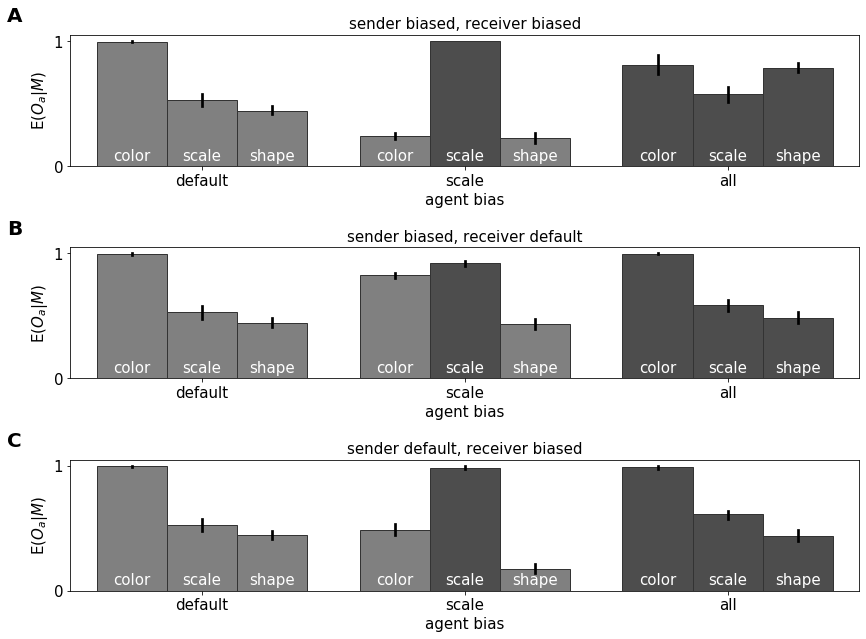

In [5]:
plot_language_bias_sender_versus_receiver(conditions, names, featurewise_effectiveness, n_biases=3, n_runs=10)

# control: flexible role agents

In [6]:
names = [['default_default', 'scale_scale', 'all_all'], 
         ['default_default', 'default_scale', 'default_all'],
         ['default_default', 'default_scale', 'default_all']]

featurewise_effectiveness = dict()
conditions = ['agent1_biased_agent2_biased', 'agent1_default_agent2_biased', 'agent1_biased_agent2_default']
for c in conditions: 
    featurewise_effectiveness[c] = dict()
vs = 4
nruns = 10
nagents = 2
mode = 'language_emergence_flexible_role'

for i in range(len(names)):
    condition = conditions[i]
    for n in names[i]: 
         featurewise_effectiveness[condition][n] = {'color': [], 'scale': [], 'shape': []}
    for run in names[i]: 
        for r in range(nruns): 
            run_name = run + str(r)
            
            c1, c2 = run.split('_')
            if c1 == c2: 
                for a in range(nagents):
                    scores = pickle.load(open('results/' + mode + '/' + run_name + '/vs' + str(vs) + 
                     '_ml3/entropy_scores' + str(a) + '.pkl', 'rb'))
            else:
                score_index = 1 if i == 1 else 0 
                scores = pickle.load(open('results/' + mode + '/' + run_name + '/vs' + str(vs) + 
                                          '_ml3/entropy_scores' + str(score_index)+ '.pkl', 'rb'))
                
            featurewise_effectiveness[condition][run]['color'].append(scores['effectiveness']['color'])
            featurewise_effectiveness[condition][run]['scale'].append(scores['effectiveness']['scale'])
            featurewise_effectiveness[condition][run]['shape'].append(scores['effectiveness']['shape'])

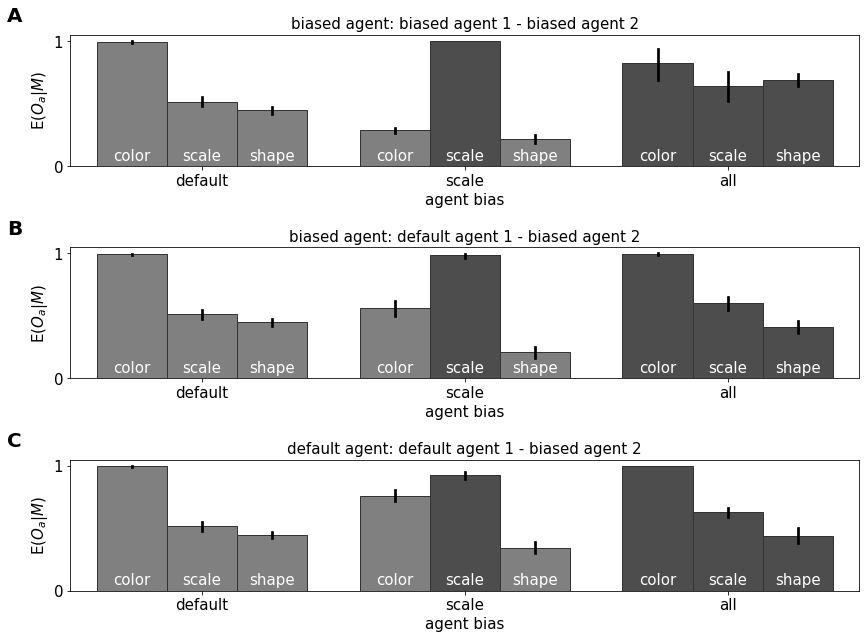

In [7]:
plot_language_bias_sender_versus_receiver(conditions, names, featurewise_effectiveness, n_biases=3, n_runs=10, flexible_role=True)

# control: mixed biases 

In [8]:
names = [['color-scale', 'color-shape', 'scale-shape']]*3

featurewise_effectiveness = dict()
conditions = ['color_irrelevant', 'scale_irrelevant', 'shape_irrelevant']
for c in conditions: 
    featurewise_effectiveness[c] = dict()
vs = 4
nruns = 20
mode = 'language_emergence_'


for i in range(len(conditions)): 
    condition = conditions[i]
    for n in names[0]: 
         featurewise_effectiveness[condition][n] = {'color': [], 'scale': [], 'shape': []}
    for run in names[0]: 
        for r in range(nruns): 
            run_name = run + str(r)
            scores = pickle.load(open('results/' + mode + condition + '/' + run_name + '/vs' + str(vs) + 
                                      '_ml3/entropy_scores.pkl', 'rb'))
            
            featurewise_effectiveness[condition][run]['color'].append(scores['effectiveness']['color'])
            featurewise_effectiveness[condition][run]['scale'].append(scores['effectiveness']['scale'])
            featurewise_effectiveness[condition][run]['shape'].append(scores['effectiveness']['shape'])

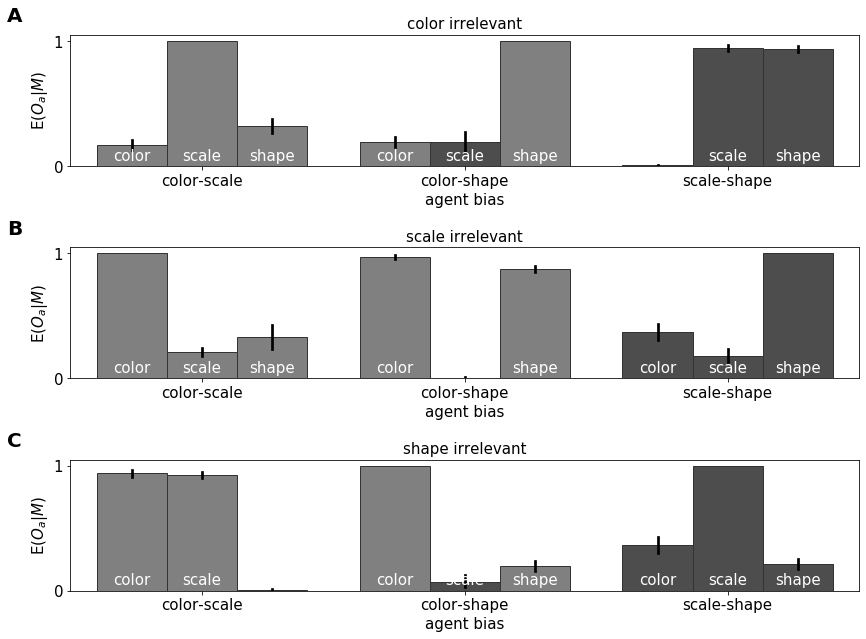

In [9]:
plot_language_bias_sender_versus_receiver(conditions, names, featurewise_effectiveness, n_biases=3, n_runs=20, mixed_bias=True)